##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>



A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

general machine learning workflow-

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.regularizers import l1_l2
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data download

In this tutorial, you will use our custom dataset. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/NewData/newdataset.zip -d /content/WPDATA

Archive:  /content/gdrive/MyDrive/NewData/newdataset.zip
   creating: /content/WPDATA/newdataset/
   creating: /content/WPDATA/newdataset/train/
   creating: /content/WPDATA/newdataset/train/grenade/
  inflating: /content/WPDATA/newdataset/train/grenade/e1105.jpg  
  inflating: /content/WPDATA/newdataset/train/grenade/e1107.jpg  
  inflating: /content/WPDATA/newdataset/train/grenade/e1108.jpg  
  inflating: /content/WPDATA/newdataset/train/grenade/e1109.jpg  
  inflating: /content/WPDATA/newdataset/train/grenade/e1110.jpg  
  inflating: /content/WPDATA/newdataset/train/grenade/e1111.jpg  
  inflating: /content/WPDATA/newdataset/train/grenade/e1112.jpg  
  inflating: /content/WPDATA/newdataset/train/grenade/e1113.jpg  
  inflating: /content/WPDATA/newdataset/train/grenade/e1114.jpg  
  inflating: /content/WPDATA/newdataset/train/grenade/e1115.jpg  
  inflating: /content/WPDATA/newdataset/train/grenade/e1116.jpg  
  inflating: /content/WPDATA/newdataset/train/grenade/e1117.jpg  
  inflat

In [ ]:
#!rm -rf /content/WPDATA/WeaponDetectionDatasetV2/train/shotgun

In [ ]:
PATH = '/content/WPDATA'

train_dir = os.path.join(PATH, 'newdataset/train')
validation_dir = os.path.join(PATH, 'newdataset/validation')


BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 3600 files belonging to 5 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 900 files belonging to 5 classes.


Show the first nine images and labels from the training set:

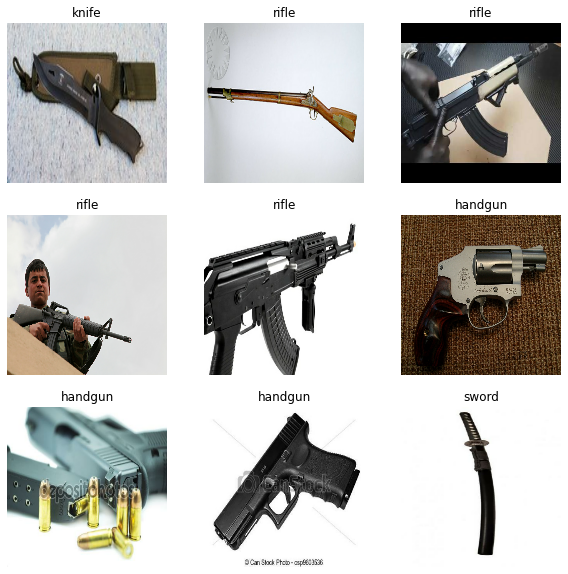

In [ ]:
class_names = np.array(train_dataset.class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 24
Number of test batches: 5


In [ ]:
print(class_names)

['grenade' 'handgun' 'knife' 'rifle' 'sword']


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
img_height = 160
img_width = 160
data_augmentation = tf.keras.Sequential(
   [
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                  input_shape=(img_height,
                                                               img_width,
                                                               3)),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
   ]
 )

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

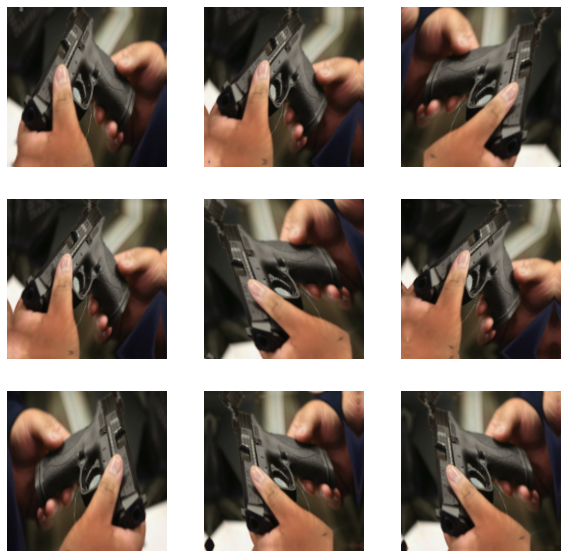

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3,  3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.Inception_ResNetV2` for use as your base model. This model expects pixel values in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## Create the base model from the pre-trained convnets
You will create the base model from the **InceptionResNetV2**. This base of knowledge will help us classify weapons from our specific dataset.

First, you need to pick which layer of InceptionResNetV2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a InceptionResNetV2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model InceptionResNetV2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

219062272/219055592 [==============================] - 1s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1536)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. InceptionResNetV2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1536)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
num_classes = len(class_names)


In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes, kernel_regularizer=l1_l2(l1=0.01, l2=0.01), bias_regularizer=l1_l2(l1=0.01, l2=0.01))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
#x = tf.keras.layers.Dense(5)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


### Compile the model

Compile the model before training it. Since there are more than two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a non-linear output.

In [ ]:
base_learning_rate= 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0     

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

### Train the model

After training for 20 epochs, here are the epochs.


In [ ]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(validation_dataset)

24/24 [==============================] - 8s 144ms/step - loss: 7.2809 - sparse_categorical_accuracy: 0.1608


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 7.28
initial accuracy: 0.16


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
113/113 [==============================] - 29s 174ms/step - loss: 5.5514 - sparse_categorical_accuracy: 0.2775 - val_loss: 3.3308 - val_sparse_categorical_accuracy: 0.6838
Epoch 2/15
113/113 [==============================] - 19s 168ms/step - loss: 4.0293 - sparse_categorical_accuracy: 0.5306 - val_loss: 2.9738 - val_sparse_categorical_accuracy: 0.8014
Epoch 3/15
113/113 [==============================] - 19s 167ms/step - loss: 3.5602 - sparse_categorical_accuracy: 0.6539 - val_loss: 2.7594 - val_sparse_categorical_accuracy: 0.8378
Epoch 4/15
113/113 [==============================] - 19s 168ms/step - loss: 3.2663 - sparse_categorical_accuracy: 0.7181 - val_loss: 2.6264 - val_sparse_categorical_accuracy: 0.8595
Epoch 5/15
113/113 [==============================] - 19s 168ms/step - loss: 3.0803 - sparse_categorical_accuracy: 0.7350 - val_loss: 2.5181 - val_sparse_categorical_accuracy: 0.8689
Epoch 6/15
113/113 [==============================] - 19s 166ms/step - loss: 2.9035 -

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the InceptionResNetV2 base model as a fixed feature extractor.

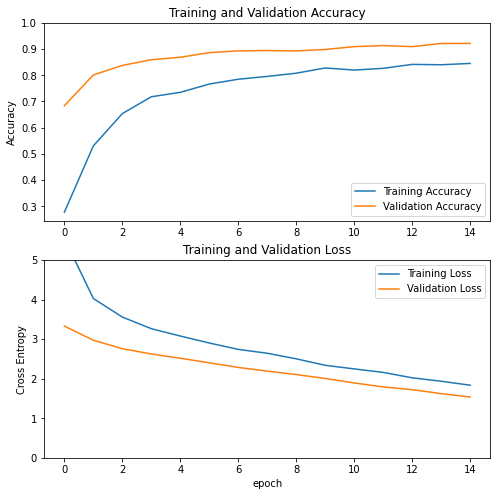

In [ ]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an InceptionResNetV2 base model. The weights of the pre-trained network were **not** updated during training.


Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole InseptionResNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
len(model.trainable_variables)

426

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 15/35
113/113 [==============================] - 72s 401ms/step - loss: 1.7397 - sparse_categorical_accuracy: 0.8344 - val_loss: 1.2805 - val_sparse_categorical_accuracy: 0.9311
Epoch 16/35
113/113 [==============================] - 42s 366ms/step - loss: 1.1857 - sparse_categorical_accuracy: 0.9206 - val_loss: 0.9967 - val_sparse_categorical_accuracy: 0.9324
Epoch 17/35
113/113 [==============================] - 42s 364ms/step - loss: 0.8649 - sparse_categorical_accuracy: 0.9361 - val_loss: 0.6961 - val_sparse_categorical_accuracy: 0.9432
Epoch 18/35
113/113 [==============================] - 42s 364ms/step - loss: 0.6168 - sparse_categorical_accuracy: 0.9486 - val_loss: 0.5481 - val_sparse_categorical_accuracy: 0.9351
Epoch 19/35
113/113 [==============================] - 41s 358ms/step - loss: 0.4595 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.6063 - val_sparse_categorical_accuracy: 0.8851
Epoch 20/35
113/113 [==============================] - 41s 360ms/step - loss: 0.

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the InceptionResNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original InceptionResNetV2 datasets.


In [ ]:
acc += history_fine.history['sparse_categorical_accuracy']
val_acc += history_fine.history['val_sparse_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1.2])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 10.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

NameError: ignored

### Evaluation and prediction

Finaly we can verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 1s 123ms/step - loss: 1.0862 - sparse_categorical_accuracy: 0.9000
Test accuracy : 0.8999999761581421


In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [ ]:
print(predicted_batch)

[[  -6.8466125    -3.326233      8.701627     -8.834454     45.656784  ]
 [  -3.0553093    28.564062     -3.23982       6.448293     -6.003322  ]
 [  -2.2172356     1.4622794    -1.1900156    11.454874     -1.3685883 ]
 [  -2.7690835    -0.7884703    28.291586     -6.410413      8.661762  ]
 [  -3.6209817    -0.76067245   29.797861     -6.676673      9.309721  ]
 [  87.78423     -17.239637    -31.503645   -100.791855    -57.63055   ]
 [  -4.010439     -1.7683012    38.059208     -8.100563     12.374985  ]
 [  -0.7681105    -0.74972266    7.7167087    -1.2955794     3.0871503 ]
 [  -1.0789376     4.5691214    -0.86985004    4.203289     -1.024782  ]
 [  -0.97180307   -0.7239319     8.556554     -1.5794388     3.6315424 ]
 [ 169.10193     -35.197823    -58.9047     -191.30975    -107.67518   ]
 [  60.056885    -14.011123    -20.55678     -67.374146    -37.650208  ]
 [  -6.1986        4.046938     -2.9572394    30.425571     -4.111335  ]
 [  -0.49770582   -0.45383152    3.6114056    -0.53

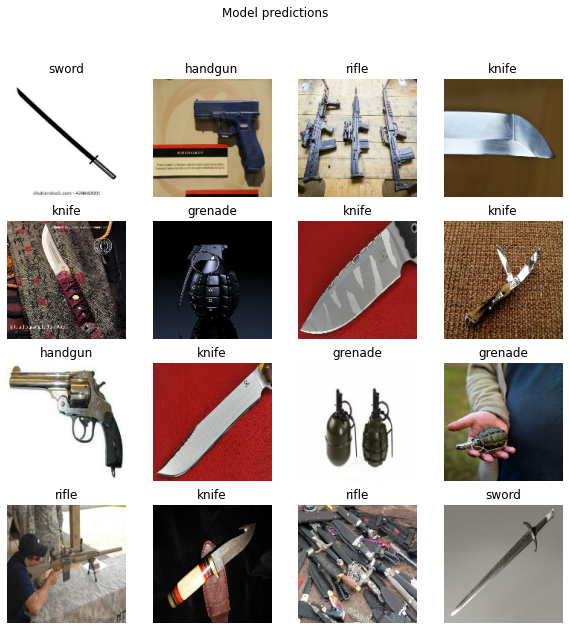

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(predicted_label_batch[i])
  plt.axis("off")
  _ = plt.suptitle("Model predictions")


INFO:tensorflow:Assets written to: /tmp/saved_models/1624613947/assets


'/tmp/saved_models/1624613947'

In [ ]:
!zip -r /content/model91.zip /tmp/saved_models/1624613947

  adding: tmp/saved_models/1624613947/ (stored 0%)
  adding: tmp/saved_models/1624613947/variables/ (stored 0%)
  adding: tmp/saved_models/1624613947/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: tmp/saved_models/1624613947/variables/variables.index (deflated 81%)
  adding: tmp/saved_models/1624613947/assets/ (stored 0%)
  adding: tmp/saved_models/1624613947/keras_metadata.pb (deflated 96%)
  adding: tmp/saved_models/1624613947/saved_model.pb (deflated 93%)


In [ ]:
from google.colab import files
files.download("/content/model91.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

And now we are all set to use this model


## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, we tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)


In [ ]:
abs(reloaded_result_batch - result_batch).max()

0.0